In [66]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom

from scipy.spatial import KDTree
from sympy import flatten


from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *
from lib.som_training import *

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4566 rows x 9 columns]
Data shape:  (4566, 3)
Star ID (HIP):  

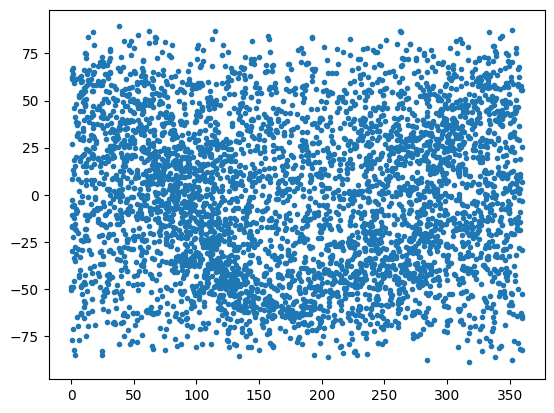

In [2]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

# delete rows with nan values
# stars_data = np.delete(stars_data, np.where(np.isnan(stars_data))[0], axis=0)

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID (HIP): ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [3]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []


feature_type_1 = 'permutation_angle_0_75_dist'
feature_type_2 = 'permutation'

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    # print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        # print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")
        
    features_1 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_1)
    features_2 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_2)
    
    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)
    # print('features_1: ', features_1)
    # print('features_2: ', features_2)

    # print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )
    # print('----------------------')

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min()) / (star_features.max() - star_features.min())
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

print("Features 1 shape: ", features_1_n.shape)
print("Features 2 shape: ", features_2_n.shape)

# Print example of the features
print("Example of the features: ")
print("Features 1: ", features_vec_1[0])
print("Features 2: ", features_vec_2[0])

norm_param = [features_vec_1.min(), features_vec_1.max(), features_vec_2.min(), features_vec_2.max()]
# norm_param = [features_vec_1.min(axis=0), features_vec_1.max(axis=0), features_vec_2.min(axis=0), features_vec_2.max(axis=0)]
print("Normalization parameters: ", norm_param)

Features 1 shape:  (4566, 10)
Features 2 shape:  (4566, 10)
Example of the features: 
Features 1:  [ 0.85661981 12.96504025  1.13139579  0.7620664   2.58149292  6.33714407
  6.63223615  3.60155994  3.35005771  2.10103782]
Features 2:  [0.26403315 3.61403621 4.33014412 4.7264928  3.41432565 4.35828078
 4.73312743 3.71788338 3.68960193 0.53448458]
Normalization parameters:  [8.721198580624508e-09, 76.81085042607027, 0.00023482725329105708, 26.108626045111873]


Star ID: 12828.0 ( 41.234935 , 10.114216 )
Neighbor ID: 12832.0 ( 41.239628 , 12.445956 )
Neighbor ID: 12153.0 ( 39.157316 , 12.447840 )
Neighbor ID: 12148.0 ( 39.146259 , 7.730073 )
Neighbor ID: 13954.0 ( 44.928738 , 8.907399 )
features_1:  [ 7.46020729  8.81239689  5.9009431   1.6369557   7.53330171 14.20612607
  8.22215565 14.79066402 13.91942824 17.64803828]
features_2:  [2.33174444 3.12446767 3.16965397 3.88594822 2.0823128  5.15962682
 5.11184133 4.71778018 6.77082253 5.90111532]
----------------------


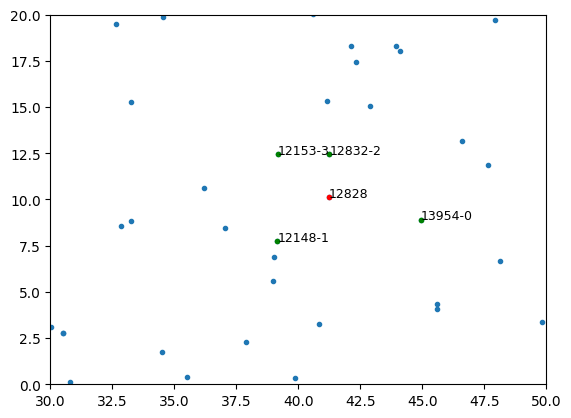

In [10]:
# Search the neighbors of a specific star

stars_sublist = [12828]

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):

    if stars_data[i][0] in stars_sublist:
        print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

        neihgtbors_list = []
        for j in range(1,n_of_neighbor+1):
            neighbor_index = indices[i][j]
            print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")
            neihgtbors_list.append(stars_data[neighbor_index][0])

        # features_vec_3.append(features_3)
        print('features_1: ', features_vec_1[i])
        print('features_2: ', features_vec_2[i])
        print('----------------------')

        plt.figure()
        plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

        plt.plot(stars_data[i,1],stars_data[i,2],'.r')
        plt.text(stars_data[i,1], stars_data[i,2], int(stars_data[i,0]), fontsize=9)

        stars_subdata = stars_data[np.where(np.isin(stars_data[:,0], neihgtbors_list))]
        plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
        #Plot the identification names of the sub set of stars
        for i in range(len(stars_subdata)):
            plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) + '-' + str(i), fontsize=9)

        #change the limits of the axis
        plt.xlim([30, 50])
        plt.ylim([0, 20])

        plt.show()  

In [11]:

## SINGLE TRAINING ##

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# mesh_size = int(np.sqrt(features_1_n.shape[0])/2)
# Manual set 

# hyperparameters_1 = {'mesh_size_1': 59, 'sigma_1': 3, 'learning_rate_1': 1.12, 'neighborhood_function_1': 'triangle', 
#  'topology_1': 'rectangular', 'activation_distance_1': 'euclidean'}
 
# hyperparameters_2 = {'mesh_size_2': 62, 'sigma_2': 3, 'learning_rate_2': 1.07,'neighborhood_function_2': 'triangle',
#  'topology_2': 'rectangular', 'activation_distance_2': 'manhattan'}

hyperparameters_1 = {
    'mesh_size1_x': 89,
    'mesh_size1_y': 86,
    'sigma_1': 2.73,
    'learning_rate_1': 1.416,
    'neighborhood_function_1': 'triangle',
    'topology_1': 'rectangular',
    'activation_distance_1': 'manhattan',
}
hyperparameters_2 = {
'mesh_size2_x': 89,
'mesh_size2_y':86,
'sigma_2': 2.78,
'learning_rate_2': 1.380,
'neighborhood_function_2': 'triangle',
'topology_2': 'rectangular',
'activation_distance_2': 'manhattan',
}

# hyperparameters = {'mesh_size_1': 60, 'mesh_size_2': 60, 'sigma': 3.263122498850444, 'learning_rate': 0.7894422310231358, 'neighborhood_function': 'triangle', 'topology': 'rectangular', 'activation_distance': 'euclidean'}

# Initialize the SOM
som1 = MiniSom(
    x = hyperparameters_1['mesh_size1_x'],
    y = hyperparameters_1['mesh_size1_y'],
    input_len = features_1_n.shape[1],

    sigma=hyperparameters_1['sigma_1'],
    learning_rate=hyperparameters_1['learning_rate_1'],
    neighborhood_function=hyperparameters_1['neighborhood_function_1'],
    topology=hyperparameters_1['topology_1'],
    activation_distance=hyperparameters_1['activation_distance_1']

)

som2 = MiniSom(
    x = hyperparameters_2['mesh_size2_x'],
    y = hyperparameters_2['mesh_size2_y'],
    input_len = features_2_n.shape[1],

    sigma=hyperparameters_2['sigma_2'],
    learning_rate=hyperparameters_2['learning_rate_2'],
    neighborhood_function=hyperparameters_2['neighborhood_function_2'],
    topology=hyperparameters_2['topology_2'],
    activation_distance=hyperparameters_2['activation_distance_2']
)

print(f"SOM 1 size = {hyperparameters_1['mesh_size1_x']} x {hyperparameters_1['mesh_size1_y']} = {hyperparameters_1['mesh_size1_x']*hyperparameters_1['mesh_size1_y']}")
print(f"SOM 2 size = {hyperparameters_2['mesh_size2_x']} x {hyperparameters_2['mesh_size2_y']} = {hyperparameters_2['mesh_size2_x']*hyperparameters_2['mesh_size2_y']}")

# Train the SOM
# som1.train_random(data=features_1_n, num_iteration=10000, verbose= True)
# # print(som1.topographic_error(features_1_n))
# som2.train_random(data=features_2_n, num_iteration=10000, verbose= True)
# print(som2.topographic_error(features_2_n))

SOM 1 size = 89 x 86 = 7654
SOM 2 size = 89 x 86 = 7654


/home/ignaciozm/.local/lib/python3.10/site-packages/minisom.py:206: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +


In [ ]:
#Quick train 
som1.train_random(data=features_1_n, num_iteration=5_700_000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=5_000_000, verbose= True)


Graphic training

In [ ]:
# Train more 

total_steps = 2_000_000
points = 100
top_error_1= []
quan_error_1 = []
for i in range(points):
    som1.train(data=features_1_n, num_iteration=total_steps//points, verbose= False)
    top_error_1.append(som1.topographic_error(features_1_n))
    quan_error_1.append(som1.quantization_error(features_1_n))
    print('\r', f'Training 1: {i*(total_steps//points)} / {total_steps} ={ (i*(total_steps//points)) / total_steps}', end='', flush=True)
print('quantization error:', som1.quantization_error(features_1_n))

total_steps = 2_000_000
n_points = 100
top_error_2 = []
quan_error_2 = []
for i in range(n_points):
    som2.train(data=features_2_n, num_iteration=total_steps//n_points, verbose= False)
    top_error_2.append(som2.topographic_error(features_2_n))
    quan_error_2.append(som2.quantization_error(features_2_n))
    print('\r', f'Training 2: {i*(total_steps//points)} / {total_steps} ={ (i*(total_steps//points)) / total_steps}', end='', flush=True)
print('quantization error:', som2.quantization_error(features_2_n))



Dictionary generation

In [6]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print(f"Quantization error 1: {som1.quantization_error(features_1_n)}")
print(f"topographic_error error 1: {som1.topographic_error(features_1_n)}")


print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
print(f"Quantization error 2: {som2.quantization_error(features_2_n)}")
print(f"topographic_error error 2: {som2.topographic_error(features_2_n)}")

som1_neuron_distribution = [0,0,0] # One, multiple, none 
som2_neuron_distribution = [0,0,0]  


# Interate over the neurons to check the stars that are stored in each neuron
for i in range(som1._xx.shape[0]):
    for j in range(som1._xx.shape[1]):
        if (i,j) in star_dict_1:
            if len(star_dict_1[(i,j)]) > 1:
                som1_neuron_distribution[1] += 1
            else:
                som1_neuron_distribution[0] += 1
        else:
            som1_neuron_distribution[2] += 1

for i in range(som2._xx.shape[0]):
    for j in range(som2._xx.shape[1]):
        if (i,j) in star_dict_2:
            if len(star_dict_2[(i,j)]) > 1:
                som2_neuron_distribution[1] += 1
            else:
                som2_neuron_distribution[0] += 1
        else:
            som2_neuron_distribution[2] += 1

print(f"SOM 1 neurons with data: { np.array(som1_neuron_distribution) / sum(som1_neuron_distribution)} ")
print(f"SOM 2 neurons with data: { np.array(som2_neuron_distribution) / sum(som2_neuron_distribution)} ")


Number of neurons with data: 4467 ; Total neurons: 7654


/home/ignaciozm/.local/lib/python3.10/site-packages/minisom.py:540: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Quantization error 1: 0.0005989109051933399
topographic_error error 1: 0.277047744196233
Number of neurons with data: 4360 ; Total neurons: 7654
Quantization error 2: 0.0005522044174353409
topographic_error error 2: 0.20017520805957073
SOM 1 neurons with data: [0.55461197 0.01097465 0.43441338] 
SOM 2 neurons with data: [0.52338646 0.02299451 0.45361902] 


In [ ]:
# ---------------------------------------------------------------------------- #
# --------------------------------- SAVE SOM --------------------------------- #    
# ---------------------------------------------------------------------------- #


import pickle

mesh_size_1 = som1.get_weights().shape[0]
mesh_size_2 = som2.get_weights().shape[0]

name = f'acc{int(cont[0] / stars_pos.shape[0] *100)}_n{str(mesh_size_1)}_{str(mesh_size_2)}_tycho{catalog_path[-5:-4]}_{feature_type_1}_{feature_type_2}'

print(name)

# Create a directory to save the SOM parameters
if not os.path.exists(f'../data/SOM_parameters/{name}'):
    os.makedirs(f'../data/SOM_parameters/{name}')

# saving the som in the file som.p
with open(f'../data/SOM_parameters/{name}/som1_{name}.p', 'wb') as outfile:
    pickle.dump([som1, som2], outfile)

# Save normalization parameters
with open(f'../data/SOM_parameters/{name}/normalization_parameters_tycho{catalog_path[-5:-4]}.p', 'wb') as outfile:
    pickle.dump([features_vec_1.min(axis=0), features_vec_1.max(axis=0), features_vec_2.min(axis=0), features_vec_2.max(axis=0)], outfile)

# Save dictionario of neurons to star
with open(f'../data/SOM_parameters/{name}/star_dict_{name}.p', 'wb') as outfile:
    pickle.dump([star_dict_1, star_dict_2], outfile)

with open(f'../data/SOM_parameters/{name}/index_{name}.p', 'wb') as outfile:
    pickle.dump(indices, outfile)


In [4]:
# ---------------------------------------------------------------------------- #
# --------------------------------- LOAD SOM --------------------------------- #    
# ---------------------------------------------------------------------------- #
import pickle

mesh_size = 80
catalog_filter = 6
name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)

name = 'acc97_n89_89_tycho6_permutation_angle_0_75_dist_permutation'
# name = 'acc97_n89_89_tycho6_permutation_multi_permutation'

#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

with open(f'../data/SOM_parameters/{name}/index_{name}.p', 'rb') as infile:
    indices = pickle.load(infile)



SOM1: Predicted Stars ID: [1274]
SOM2: Predicted Stars ID: [1274, 1637, 3521]
Final guess: 1274, actual star ID: 1274


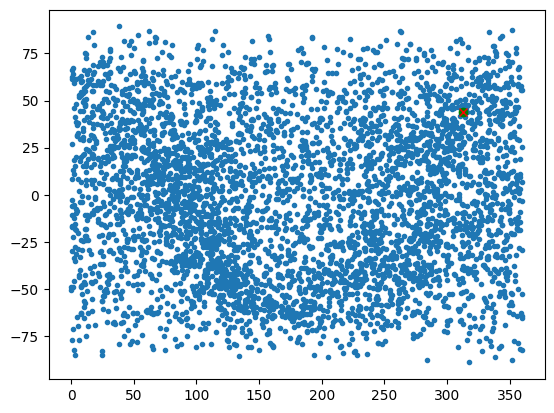

In [59]:
from lib.event_processing import predict_star_id
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))
# random_id = np.where(stars_data[:,0] == 12828)[0][0] # To check the prediction of a specific star (not that random)

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1, [features_vec_1.min(), features_vec_1.max()], star_dict_1, som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2, [features_vec_2.min(), features_vec_2.max()], star_dict_2, som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
else:
    star_guess = None

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guess: {star_guess}, actual star ID: {random_id}")

if star_guess is not None:
    plt.figure()
    plt.plot(stars_data[:,1],stars_data[:,2],'.')
    plt.plot(stars_data[random_id][1],stars_data[random_id][2],'og')
    plt.plot(stars_data[star_guess][1],stars_data[star_guess][2],'xr')
    plt.show()


Normal star check (without validation)

In [49]:
noise = generate_pixel_noise(stars_data.shape, 10)
print('shape: ', noise.shape)
print('mean', np.mean(noise))
print('std', np.std(noise))
print('max', np.max(noise))
print('min', np.min(noise))

Pixels:  0.1171875
shape:  (4566, 2)
mean 0.0012941511907157378
std 0.08285396943309697
max 0.11718745533605136
min -0.11718749992963191


In [68]:
noise = generate_gaussian_pixel_noise(stars_data.shape, 10)
print('shape: ', noise.shape)
print('mean', np.mean(noise))
print('std', np.std(noise))
print('max', np.max(noise))
print('min', np.min(noise))

Std pixels:  0.1171875
shape:  (4566, 3)
mean 0.00027009642377805827
std 0.11696414199425795
max 0.4603241294356275
min -0.4649876762644791


In [70]:
import time 
from lib.event_processing import predict_star_id


cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
acc = np.zeros(2) # [correct SOM1, correct SOM2]

stars_pos = np.copy(stars_data[:,1:3])



# Pixel scaled noise
# noise = generate_pixel_noise(stars_data.shape, 10)
noise = generate_gaussian_pixel_noise(stars_data[:,0:2].shape, 5)
mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
stars_pos += noise

mean_time = 0

time_start = time.time()

som1_activate_data = []
som2_activate_data = []

features_1_noisy = []
features_2_noisy = []

correct_ids = []

for i in range(len(stars_pos)):
    features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
    features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
        
    # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    # feature_type_1 = 'permutation_multi'
    # feature_type_2 = 'permutation'

    features_1_noisy.append(features_1) 
    features_2_noisy.append(features_2)

    winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
    winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1
    

    if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = winner_ids_2
    elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = winner_ids_1
    else:
        star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
            star_guess = (winner_ids_1)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
            star_guess = (winner_ids_2)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = winner_ids_1
            else:
                star_guess = winner_ids_2

    

    # Accuracy count
    if len(star_guess) == 1:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
        if star_guess[0] == i:
            correct_ids.append(i)
    else:
        # print("Error: ", list(set(winner_ids_1).intersection(winner_ids_2)), "!=", i)
        if len(star_guess) == 0: # If no match

            if i in winner_ids_1:
                cont[3] += 1
            elif i in winner_ids_2:
                cont[4] += 1
            else:  
                cont[5] += 1

            # print("gt:", i)
            # print("ids 1:", winner_ids_1, "activation: ", act_som1.min() ) 
            # print("ids 2:", winner_ids_2, "activation: ", act_som2.min() )
            # print('----------------------')

            if len(winner_ids_1) == 1 and len(winner_ids_2) == 1:
                if i in winner_ids_1 and act_som1.min() < act_som2.min():
                    cont_no_match[0] += 1
                elif i in winner_ids_2 and act_som2.min() < act_som1.min():
                    cont_no_match[1] += 1
                else:
                    cont_no_match[2] += 1
                


        cont[2] += len(star_guess) > 1
time_end = time.time()


print('number of cases:', np.sum(cont[0:6]), 'len: ', len(stars_pos))
print("mean noise level=",  mean_noise, 'noise example: ', stars_data[0][1:3]-stars_pos[0])
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
print(f"total success = {cont[0:6] / stars_pos.shape[0]} = {np.sum(cont[0:6]) / stars_pos.shape[0]}")
print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]")
print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
# print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])

# Save the results in a list variable
results_1 = [ cont[0:4] / stars_pos.shape[0], acc[0] / stars_pos.shape[0], acc[1] / stars_pos.shape[0], (time_end - time_start) / stars_pos.shape[0]]

Std pixels:  0.05859375
number of cases: 4566.0 len:  4566
mean noise level= 0.0733528019978378 noise example:  [-0.02931  0.02968]
total success = [ 0.97788  0.01621  0.00526  0.00000  0.00066  0.00000] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.9728427507665353  SOM2 success: 0.9932106876916338
total time= 5.868378162384033
total time per star= 0.001285233938323266


Noise caracterization 

In [71]:
pixel_to_deg= {
    'ref_pixel_to_deg': 0.0009601418439716312, # [deg/pixel] In degres from sun_calibration with FOV=reference_FOV
    'reference_FOV': 1, #In degrees. FOV o the sun calibration recording
    'recording_FOV': 14.3, #In degrees. FOV of the stars recording
  }
pixel_to_deg_conv = pixel_to_deg['ref_pixel_to_deg'] / pixel_to_deg['reference_FOV'] * pixel_to_deg['recording_FOV']

print(" ----  Noise over position ---- ")
# print(f' Noise over position in percentage: {mean_noise*100} % ')
# noise_value_average = np.mean(np.abs(noise*stars_pos[0]-stars_pos[0]), axis=0 ) 
# print(f' Noise value average: {noise_value_average} [deg]')
# print(f' Pixel equivalence to position noise: {noise_value_average/pixel_to_deg_conv} pixels')
print(f' Position witout noise: {stars_pos[0]}')
print(f' Position with noise: {noise[0]*stars_pos[0]} ')
print(f' Position of neighbor strars: \n {stars_pos[indices[0][0:n_of_neighbor+1]]} ')

print(" ----  Noise over features  ---- ")

average_features_1_noise = np.mean(np.abs(np.array(features_1_noisy) - np.array(features_vec_1)), axis=0) 
average_features_2_noise = np.mean(np.abs(np.array(features_2_noisy) - np.array(features_vec_2)), axis=0) 
features_1_mean = np.mean(np.array(features_vec_1), axis=0)
features_2_mean = np.mean(np.array(features_vec_2), axis=0)

print(f' Average features 1 noise: {average_features_1_noise/features_1_mean} ')
print(f' Average features 2 noise: {average_features_2_noise/features_2_mean} ')

 ----  Noise over position ---- 
 Position witout noise: [ 45.59922  4.06024]
 Position with noise: [ 1.33637 -0.12052] 
 Position of neighbor strars: 
 [[ 45.59922  4.06024]
 [ 45.53571  4.26963]
 [ 48.15428  6.68832]
 [ 49.76736  3.34522]
 [ 50.32681  3.69496]] 
 ----  Noise over features  ---- 
 Average features 1 noise: [ 0.05048  0.03275  0.02440  0.02198  0.04323  0.04034  0.03980  0.02138
  0.02025  0.01759] 
 Average features 2 noise: [ 0.03807  0.02518  0.01965  0.01687  0.02261  0.01812  0.01589  0.01774
  0.01510  0.01490] 


In [72]:
import time 
from lib.event_processing import predict_star_id


results_vec = []
for n_to_avg in range(5):
    results = []
    for n_pixels in range(11):


        cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
        cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
        acc = np.zeros(2) # [correct SOM1, correct SOM2]

        stars_pos = np.copy(stars_data[:,1:3])

        # Pixel scaled noise
        # noise = generate_pixel_noise(stars_data.shape, n_pixels)
        noise = generate_gaussian_pixel_noise(stars_data[:,0:2].shape, n_pixels)

        mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
        stars_pos += noise

        mean_time = 0

        time_start = time.time()

        som1_activate_data = []
        som2_activate_data = []

        features_1_noisy = []
        features_2_noisy = []

        for i in range(len(stars_pos)):
            features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
            features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
                
            # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
            # feature_type_1 = 'permutation_multi'
            # feature_type_2 = 'permutation'

            features_1_noisy.append(features_1) 
            features_2_noisy.append(features_2)

            winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
            winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

            if i in winner_ids_1 and len(winner_ids_1) < 20:
                acc[0] += 1
            if i in winner_ids_2 and len(winner_ids_2) < 20:
                acc[1] += 1
            

            if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
                star_guess = winner_ids_2
            elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
                star_guess = winner_ids_1
            else:
                star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

            if len(star_guess) == 0: # Second guees 
                if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
                    star_guess = (winner_ids_1)
                elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
                    star_guess = (winner_ids_2)
                elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
                    act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
                    act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
                    if act_som1.min() < act_som2.min():
                        star_guess = winner_ids_1
                    else:
                        star_guess = winner_ids_2

            # Accuracy count
            if len(star_guess) == 1:
                cont[0] += star_guess[0] == i
                cont[1] += star_guess[0] != i
            else:
                if len(star_guess) == 0: # If no match



                    if i in winner_ids_1:
                        cont[3] += 1
                    elif i in winner_ids_2:
                        cont[4] += 1
                    else:  
                        cont[5] += 1

                    if len(winner_ids_1) == 1 and len(winner_ids_2) == 1:
                        if i in winner_ids_1 and act_som1.min() < act_som2.min():
                            cont_no_match[0] += 1
                        elif i in winner_ids_2 and act_som2.min() < act_som1.min():
                            cont_no_match[1] += 1
                        else:
                            cont_no_match[2] += 1

                cont[2] += len(star_guess) > 1
        time_end = time.time()


        print('number of cases:', np.sum(cont[0:6]), 'len: ', len(stars_pos))
        print("mean noise level=",  mean_noise, 'noise example: ', stars_data[0][1:3]-stars_pos[0])
        np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
        print(f"total success = {cont[0:6] / stars_pos.shape[0]} = {np.sum(cont[0:6]) / stars_pos.shape[0]}")
        print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]")
        print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
        # print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
        print("total time=",  time_end - time_start)
        print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])

        # Save the results in a list variable
        results.append( [ cont[0:6] / stars_pos.shape[0], acc / stars_pos.shape[0], (time_end - time_start) / stars_pos.shape[0]])
    results_vec.append(results)

Std pixels:  0.0
number of cases: 4566.0 len:  4566
mean noise level= 0.0 noise example:  [ 0.00000  0.00000]
total success = [ 0.99562  0.00000  0.00438  0.00000  0.00000  0.00000] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 1.0  SOM2 success: 1.0
total time= 4.929924726486206
total time per star= 0.0010797031814468257
Std pixels:  0.01171875
number of cases: 4566.0 len:  4566
mean noise level= 0.014670663388869262 noise example:  [-0.00587  0.00127]
total success = [ 0.98292  0.01205  0.00482  0.00000  0.00022  0.00000] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.986640385457731  SOM2 success: 0.9995619798510732
total time= 5.129672050476074
total time per star= 0.0011234498577477167
Std pixels:  0.0234375
number of cases: 4566.0 len:  4566
mean noise level= 0.029044539757422713 noise example:  [-0.04820  0.00293]
total succes